In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

# Data Input

In [2]:
message = pd.read_csv("/Users/arnabdey/Documents/MyCodes/ChatGPT finternship/Microsoft Data/MSFT_2012-06-21_34200000_57600000_message_5.csv", header=None)
orderbook = pd.read_csv("/Users/arnabdey/Documents/MyCodes/ChatGPT finternship/Microsoft Data/MSFT_2012-06-21_34200000_57600000_orderbook_5.csv", header=None)
message.columns = ["Time", "Type", "Order ID", "Size", "Price", "Direction"]
order_columns = []
for i in range(5):
    order_columns += [f"Ask Price {i+1}", f"Ask Size {i+1}", f"Bid Price {i+1}", f"Bid Size {i+1}"]
orderbook.columns = order_columns
base_date = datetime(2012, 6, 21)
message['datetime'] = message['Time'].apply(lambda x: base_date + timedelta(seconds=x))
orderbook['datetime'] = message['datetime']
orderbook.set_index('datetime', inplace=True)

In [3]:
print(f"Message\n{message.head(2)}\nOrder Book\n{orderbook.head(2)}")

Message
           Time  Type  Order ID  Size   Price  Direction  \
0  34200.013994     3  16085616   100  310400         -1   
1  34200.013994     1  16116348   100  310500         -1   

                    datetime  
0 2012-06-21 09:30:00.013994  
1 2012-06-21 09:30:00.013994  
Order Book
                            Ask Price 1  Ask Size 1  Bid Price 1  Bid Size 1  \
datetime                                                                       
2012-06-21 09:30:00.013994       309900        3788       309500         300   
2012-06-21 09:30:00.013994       309900        3788       309500         300   

                            Ask Price 2  Ask Size 2  Bid Price 2  Bid Size 2  \
datetime                                                                       
2012-06-21 09:30:00.013994       310500         100       309300        3986   
2012-06-21 09:30:00.013994       310500         200       309300        3986   

                            Ask Price 3  Ask Size 3  Bid Price 3 

# Market Microstructure Analyis

## Exploratory Data analysis

### Plot average bid-ask spread over time

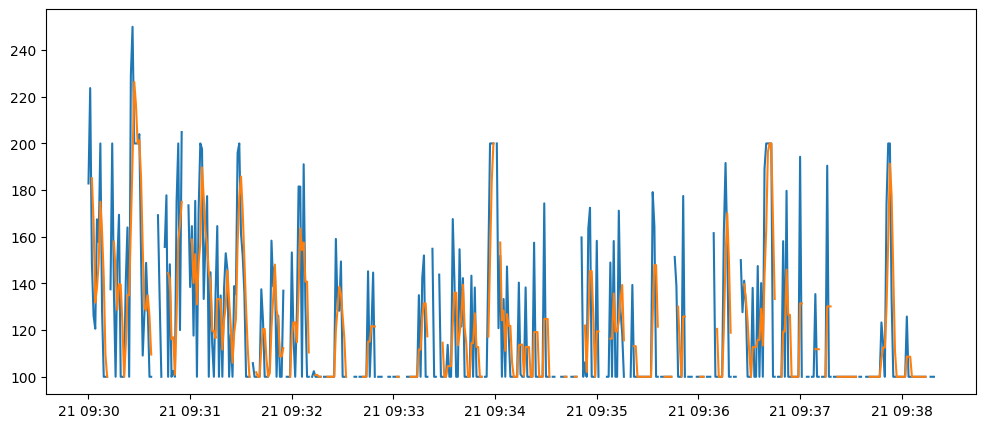

In [4]:
orderbook["spread"] = orderbook["Ask Price 1"] - orderbook["Bid Price 1"]
spread_1s = orderbook['spread'].resample('1S').mean()
plt.figure(figsize=(12, 5))
plt.plot(spread_1s[:500])
plt.plot(spread_1s[:500].rolling(window=3).mean())
plt.show()

### Distribution of Order Depths

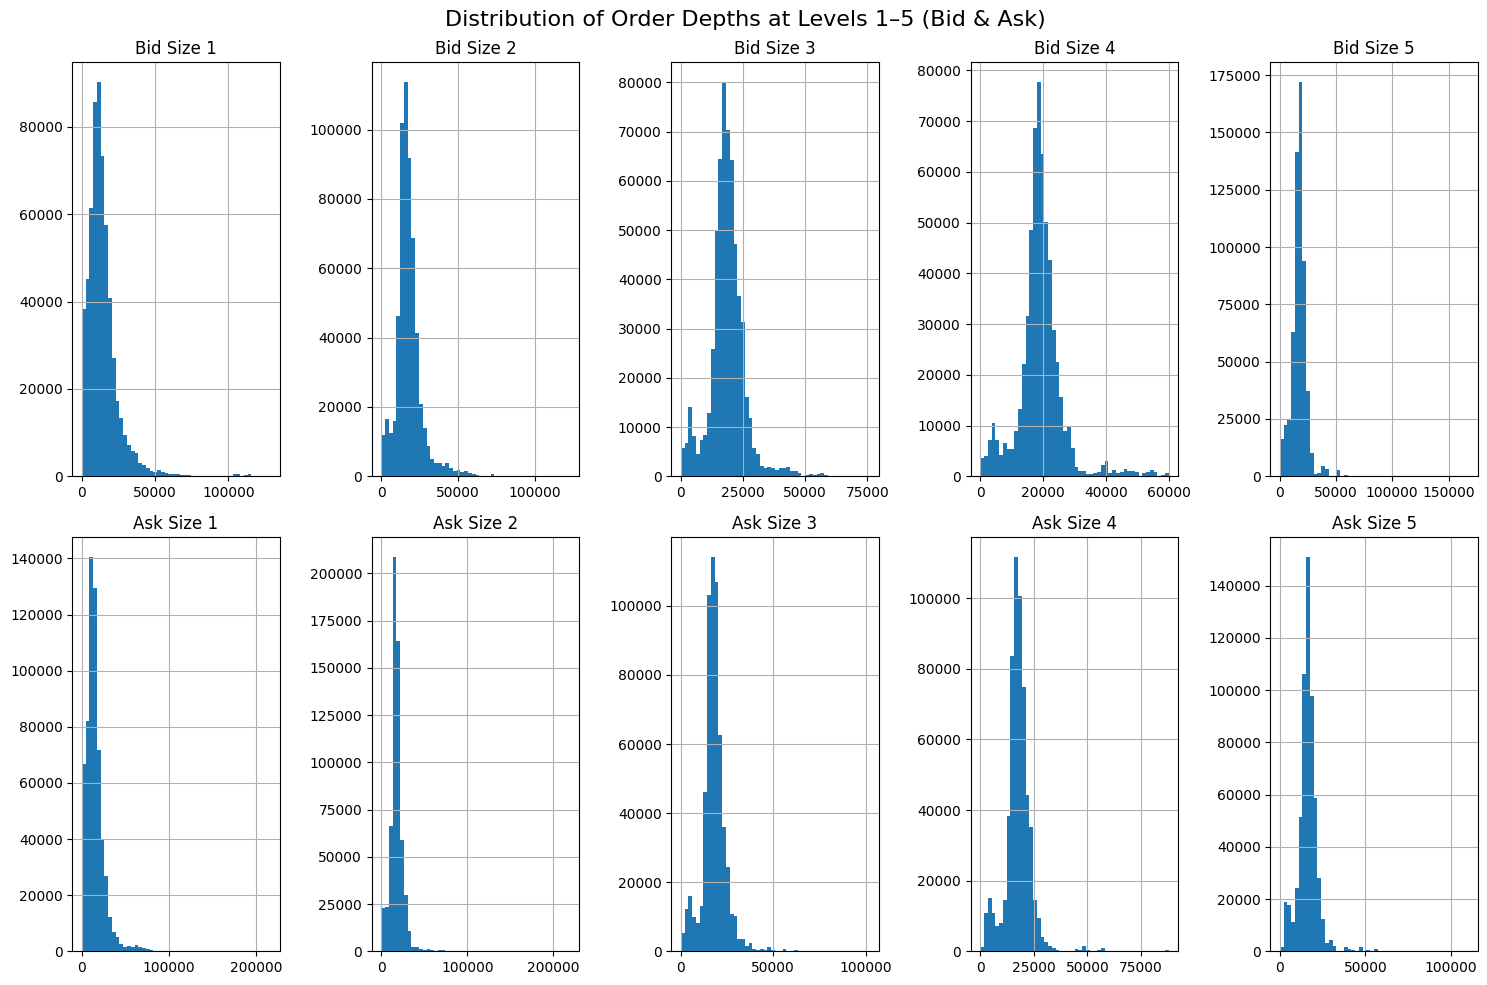

In [5]:
Depth_Cols = [f"Bid Size {i+1}" for i in range(5)] + [f"Ask Size {i+1}" for i in range(5)]
orderbook[Depth_Cols].hist(bins=50, figsize=(15, 10), layout=(2, 5))
plt.suptitle("Distribution of Order Depths at Levels 1–5 (Bid & Ask)", fontsize=16)
plt.tight_layout()
plt.show()

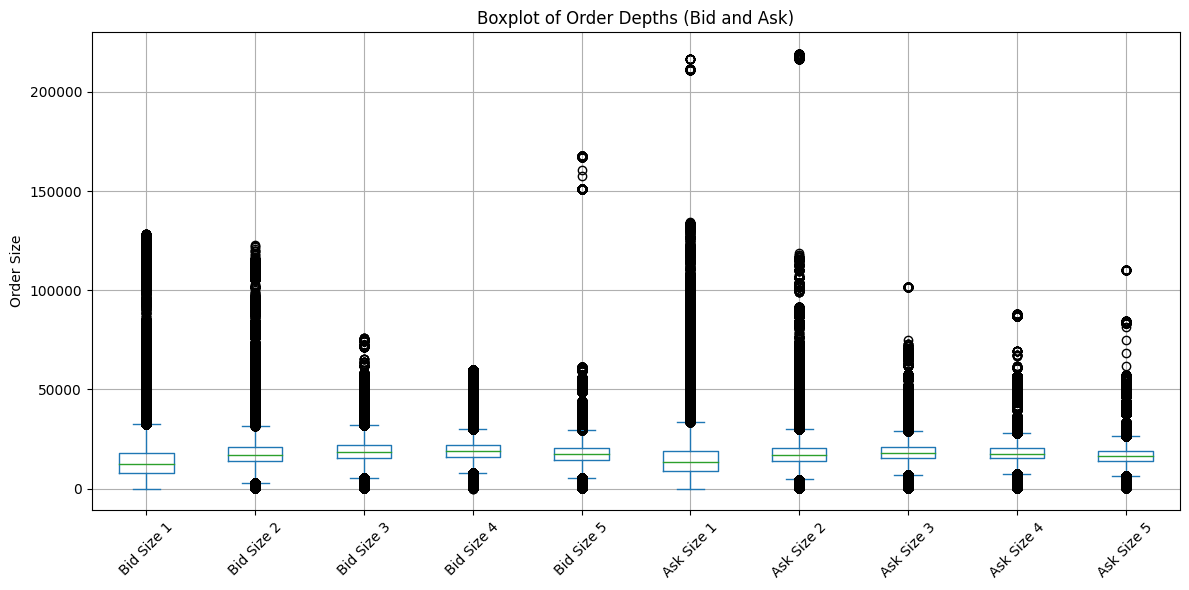

In [6]:
orderbook[Depth_Cols].plot(kind='box', figsize=(12, 6))
plt.title("Boxplot of Order Depths (Bid and Ask)")
plt.ylabel("Order Size")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualising Mid-Price Changes

$\mathrm{Mid Price}(t) = \frac{\mathrm{Best Ask}(t)+\mathrm{Best Bid}(t)}{2}$

In [7]:
orderbook["mid_price"] = (orderbook["Ask Price 1"] + orderbook["Bid Price 1"]) / 2

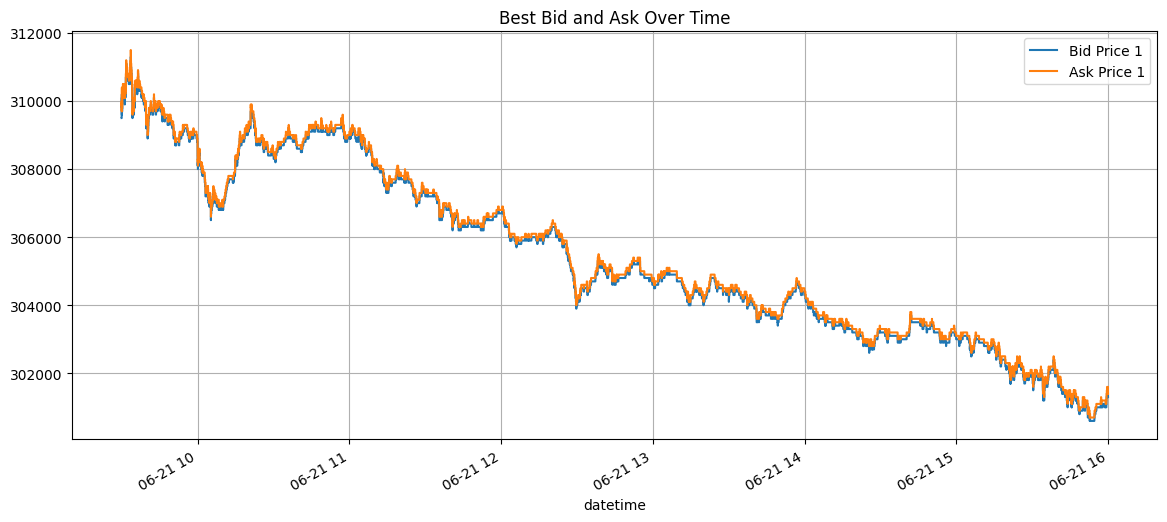

In [8]:
orderbook[['Bid Price 1', 'Ask Price 1']].plot(figsize=(14, 6))
plt.title("Best Bid and Ask Over Time")
plt.grid(True)
plt.show()

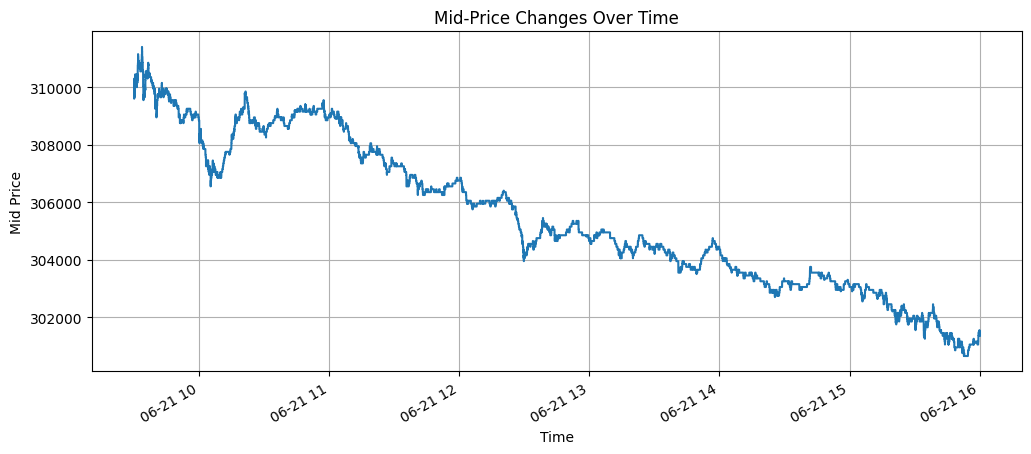

In [9]:
plt.figure(figsize=(12, 5))
orderbook["mid_price"].plot()
plt.title("Mid-Price Changes Over Time")
plt.xlabel("Time")
plt.ylabel("Mid Price")
plt.grid(True)
plt.show()

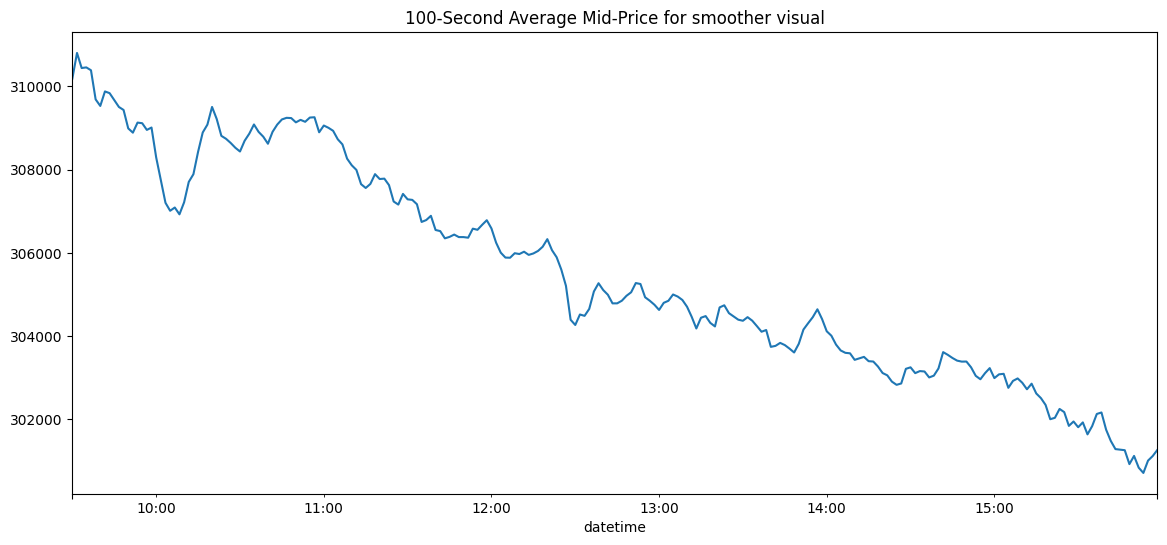

In [10]:
orderbook["mid_price"].resample('100S').mean().plot(figsize=(14, 6))
plt.title("100-Second Average Mid-Price for smoother visual")
plt.show()

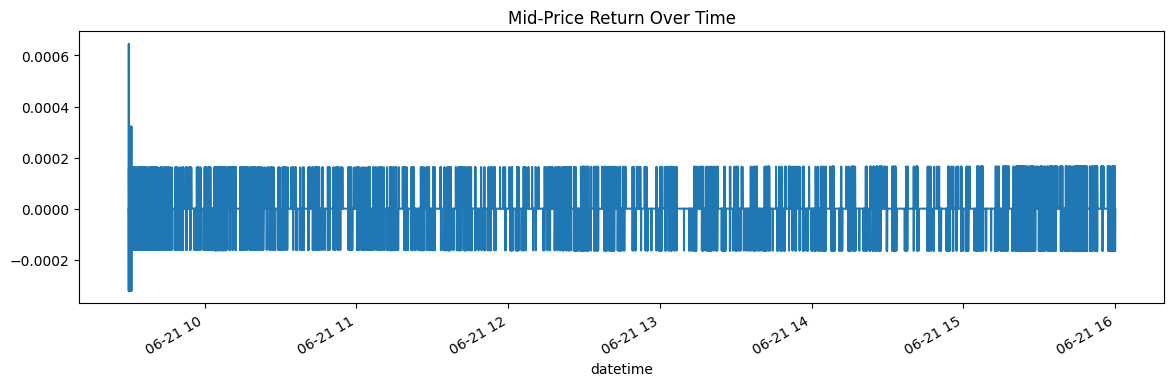

In [11]:
orderbook['mid_price_return'] = orderbook['mid_price'].pct_change()
orderbook['mid_price_return'].plot(figsize=(14, 4), title="Mid-Price Return Over Time")
plt.show()

## Feature Engineering

In [12]:
orderbook["Price Imbalance"] = orderbook["Bid Size 1"] / (orderbook["Bid Size 1"] + orderbook["Ask Size 1"])

$\mathrm{Price Imbalance}=\frac{\mathrm{Bid Size}_1}{\mathrm{Bid Size}_1 + \mathrm{Ask Size}_1} $

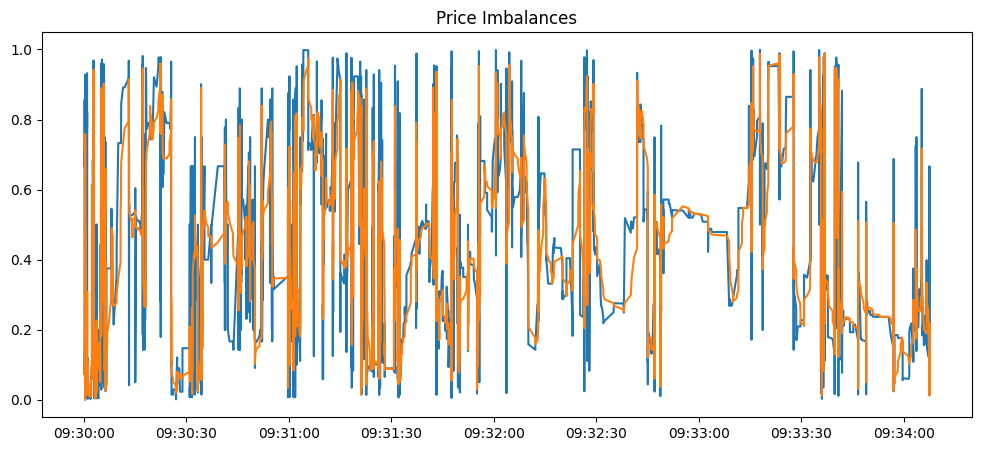

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(orderbook["Price Imbalance"][0:10000])
plt.plot(orderbook["Price Imbalance"][0:10000].rolling(window=10).mean())
plt.title("Price Imbalances")
plt.show()

$\mathrm{OFI}_t=(\Delta \mathrm{Bid Size}_1) \cdot I_{\mathrm{Bid Price Unchanged}} - (\Delta \mathrm{Ask Size}_1) \cdot I_{\mathrm{Ask Price Unchanged}} $

In [14]:
delta_bid_size = orderbook["Bid Size 1"].diff()
delta_ask_size = orderbook["Ask Size 1"].diff()
delta_bid_price_un = orderbook["Bid Price 1"].diff().abs() < 1e-9
delta_ask_price_un = orderbook["Ask Price 1"].diff().abs() < 1e-9
orderbook["OFI"] = delta_bid_size * delta_bid_price_un.astype(int) - delta_ask_size * delta_ask_price_un.astype(int)

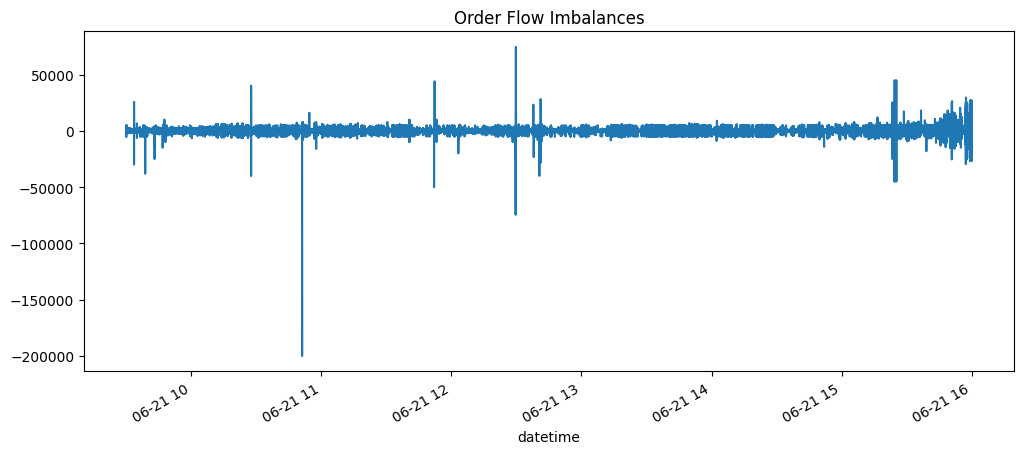

In [15]:
plt.figure(figsize=(12, 5))
orderbook["OFI"].plot()
plt.title("Order Flow Imbalances")
plt.show()

*Buy and Sell Crossings*

$$\text{Buy Crossing : Mid Price > Previous Ask}\\ \text{Sell Crossing : Mid Price < Previous Bid}$$

In [16]:
buy_crossings = orderbook["mid_price"] > orderbook["Ask Price 1"].shift(1)
sell_crossings = orderbook["mid_price"] < orderbook["Bid Price 1"].shift(1)

orderbook["Cumulative Spread Crossing"] = (buy_crossings.astype(int) + sell_crossings.astype(int)).cumsum()

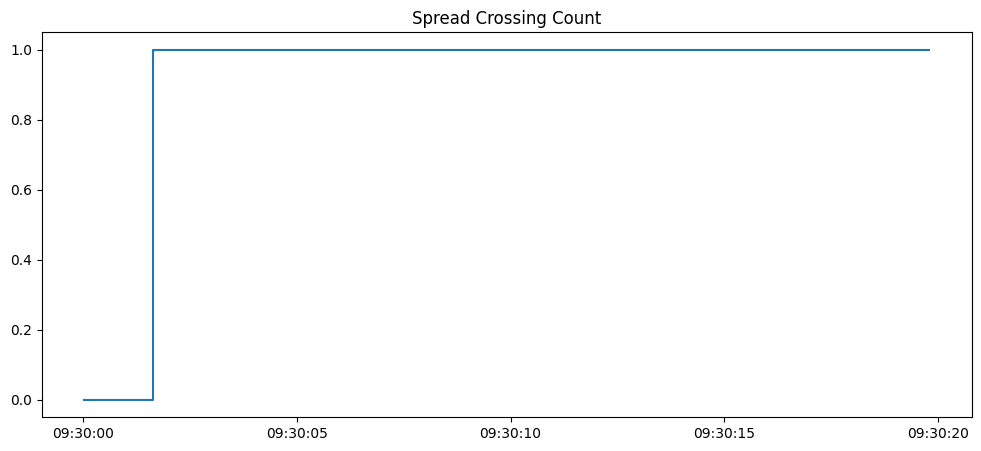

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(orderbook["Cumulative Spread Crossing"][0:1000])
plt.title("Spread Crossing Count")
plt.show()

# Predicting Short-Term Price Movement

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
# import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Label Generation

In [20]:
def create_data_labels(dataframe, column_name, delta_t):
    future_Price = dataframe[column_name].shift(-delta_t)
    current_Prices = dataframe[column_name]

    labels = (future_Price > current_Prices).astype(int) - (future_Price < current_Prices).astype(int)
    return labels
def create_features_for_prediction(dataframe, delta_t):
    features = pd.DataFrame(index=orderbook.index)
    features["mid_price"] = orderbook["mid_price"]
    features["spread"] = orderbook["spread"]
    features["Price Imbalance"] = orderbook["Price Imbalance"]
    features["Total Bid Depth"] = orderbook[[f"Bid Size {i+1}" for i in range(5)]].sum(axis=1)
    features["Total Ask Depth"] = orderbook[[f"Ask Size {i+1}" for i in range(5)]].sum(axis=1)
    features["OFI"] = orderbook["OFI"]
    features["Seconds Since Open"] = (orderbook.index - orderbook.index[0]).total_seconds()
    features["label"] = create_data_labels(orderbook, "mid_price", delta_t=delta_t)

    features.dropna(inplace=True)
    return features

## Comparisons
$$\text{Random Forest Classifier}\\ \text{Logistic Regression}$$

### $\Delta t = 10$

In [ ]:
features = create_features_for_prediction(dataframe=orderbook, delta_t=10)
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns="label"), features["label"], test_size=0.15, shuffle=False)
RF_Classifier = RandomForestClassifier()
logistic_regressor = linear_model.LogisticRegression()
RF_Classifier.fit(X_train, y_train)
logistic_regressor.fit(X_train, y_train)
XG_Boost_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, max_depth=5)
XG_Boost_classifier.fit(X_train, y_train+1)

print(f"XGBoost Accuracy : \t\t{XG_Boost_classifier.score(X_test, y_test+1)}")
print(f"Random Forest Accuracy: \t{RF_Classifier.score(X_test, y_test)}")
print(f"Logistic Regression Accuracy: \t{logistic_regressor.score(X_test, y_test)}")

/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBoost Accuracy : 	0.9547946738279065
Random Forest Accuracy: 	0.9100928723285219
Logistic Regression Accuracy: 	0.954168065346313


### $\Delta t = 20$

In [ ]:
features = create_features_for_prediction(dataframe=orderbook, delta_t=20)
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns="label"), features["label"], test_size=0.15, shuffle=False)
RF_Classifier = RandomForestClassifier()
logistic_regressor = linear_model.LogisticRegression()
RF_Classifier.fit(X_train, y_train)
logistic_regressor.fit(X_train, y_train)
XG_Boost_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, max_depth=5)
XG_Boost_classifier.fit(X_train, y_train+1)

print(f"XGBoost Accuracy : \t\t{XG_Boost_classifier.score(X_test, y_test+1)}")
print(f"Random Forest Accuracy: \t{RF_Classifier.score(X_test, y_test)}")
print(f"Logistic Regression Accuracy: \t{logistic_regressor.score(X_test, y_test)}")

/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBoost Accuracy : 	0.910495692066689
Random Forest Accuracy: 	0.9024281078661743
Logistic Regression Accuracy: 	0.9121852970795569


### $\Delta t = 50$

In [33]:
features = create_features_for_prediction(dataframe=orderbook, delta_t=50)
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns="label"), features["label"], test_size=0.15, shuffle=False)
RF_Classifier = RandomForestClassifier()
logistic_regressor = linear_model.LogisticRegression()
RF_Classifier.fit(X_train, y_train)
logistic_regressor.fit(X_train, y_train)
XG_Boost_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, max_depth=5)
XG_Boost_classifier.fit(X_train, y_train+1)

print(f"XGBoost Accuracy : \t\t{XG_Boost_classifier.score(X_test, y_test+1)}")
print(f"Random Forest Accuracy: \t{RF_Classifier.score(X_test, y_test)}")
print(f"Logistic Regression Accuracy: \t{logistic_regressor.score(X_test, y_test)}")

/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBoost Accuracy : 	0.7963634329193242
Random Forest Accuracy: 	0.762280407295513
Logistic Regression Accuracy: 	0.8185856551415464


### Compare against MLP

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
device = 'cuda'

scaler = StandardScaler()
torch.set_float32_matmul_precision("high")

In [36]:
print(X_train.shape)

(506429, 7)


In [38]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=7, out_features=32),
            nn.GELU(),
            nn.Linear(in_features=32, out_features=64),
            nn.GELU(),
            nn.Linear(in_features=64, out_features=3)
        )
    def forward(self, x):
        return self.fc(x)

In [82]:
MyMLP = MLP()
MyMLP = torch.compile(MyMLP).to(device)

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(MyMLP.parameters(), lr=1e-3)

In [84]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_mapped = y_train + 1

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long)
# one_hot_labels = F.one_hot(y_train_tensor, num_classes=3)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=1024)

In [85]:
epochs = 100

In [86]:
Losses = []
for epoch in tqdm(range(epochs)):
    for data in train_dataloader:
        X,y = data
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = MyMLP(X)
        loss = criterion(outputs, y)
        Losses.append(loss.item())
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [07:47<00:00,  4.68s/it]


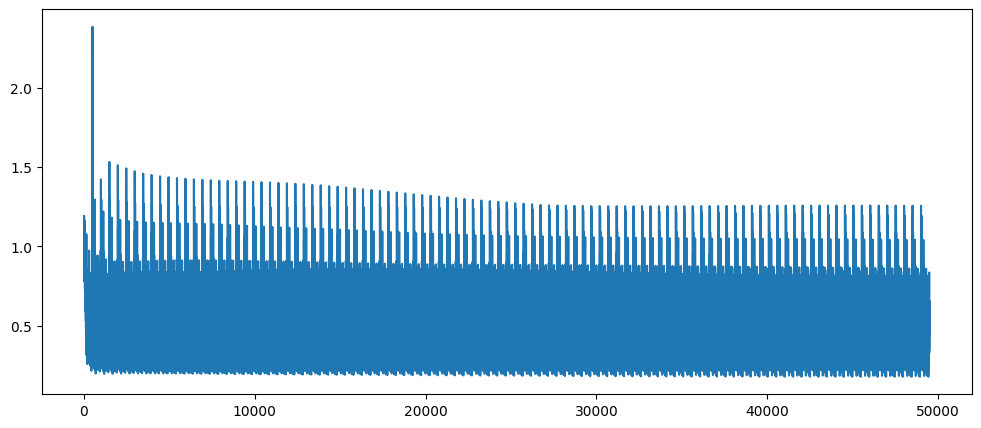

In [87]:
plt.figure(figsize=(12, 5))
plt.plot(Losses)
plt.show()

In [78]:
y_test_mapped = y_test + 1

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long)
# test_dataset = TensorDataset(X_test_tensor)
# test_dataloader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=1024)

In [81]:
with torch.no_grad():
    y_pred = MyMLP(X_test_tensor.to(device))
    _, predicted_classes = torch.max(y_pred, 1)

y_true = y_test_tensor.cpu().numpy()
y_pred = predicted_classes.cpu().numpy()

print(f"MLP Accuracy :\t{accuracy_score(y_true, y_pred)}")

MLP Accuracy :	0.7527358173883854


# Trading Signal Generation and Backtesting

In [21]:
features = create_features_for_prediction(dataframe=orderbook, delta_t=10)
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns="label"), features["label"], test_size=0.15, shuffle=False)

RF_Classifier = RandomForestClassifier()
RF_Classifier.fit(X_train, y_train)
y_pred = RF_Classifier.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


## Execution at Next Mid Price or with Slippage

### Next Mid Price

In [22]:
signal_stream = pd.DataFrame(index=X_test.index)
signal_stream["Predicted Label"] = y_pred

signal_map = {-1: 'Sell', 0: 'Hold', 1:'Buy'}
signal_stream["signal"] = signal_stream["Predicted Label"].map(signal_map)
orderbook_uniq = orderbook[~orderbook.index.duplicated(keep='last')]
signal_stream["mid_price"] = orderbook_uniq["mid_price"].reindex(signal_stream.index)
signal_stream["next_mid"] = signal_stream["mid_price"].shift(-1)
signal_stream.dropna(subset=["next_mid"], inplace=True)
buy_signals = signal_stream[signal_stream["signal"] == "Buy"]
sell_signals = signal_stream[signal_stream["signal"] == "Sell"]

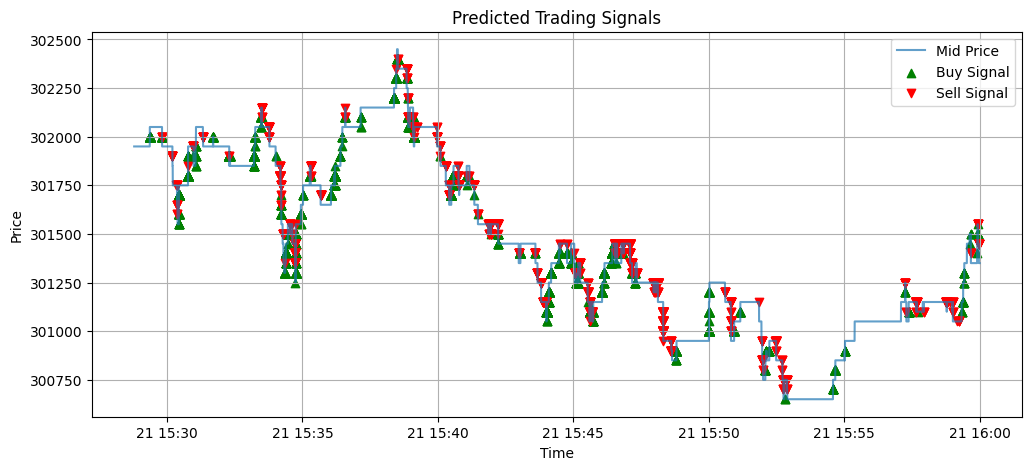

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(signal_stream["mid_price"], label="Mid Price", alpha=0.7)
plt.scatter(buy_signals.index, buy_signals["mid_price"], color="green", label="Buy Signal", marker='^')
plt.scatter(sell_signals.index, sell_signals["mid_price"], color="red", label="Sell Signal", marker='v')
plt.legend()
plt.title("Predicted Trading Signals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### Simulate Slippage

In [24]:
Tick_Size = 1e-4
def simulate_slippage(row):
    if row['signal'] == 'Buy':
        return row['next_mid'] + 0.5 * Tick_Size
    elif row['signal'] == 'Sell':
        return row['next_mid'] - 0.5 * Tick_Size
    else:
        return np.nan
signal_stream["exec_price"] = signal_stream.apply(simulate_slippage, axis=1)

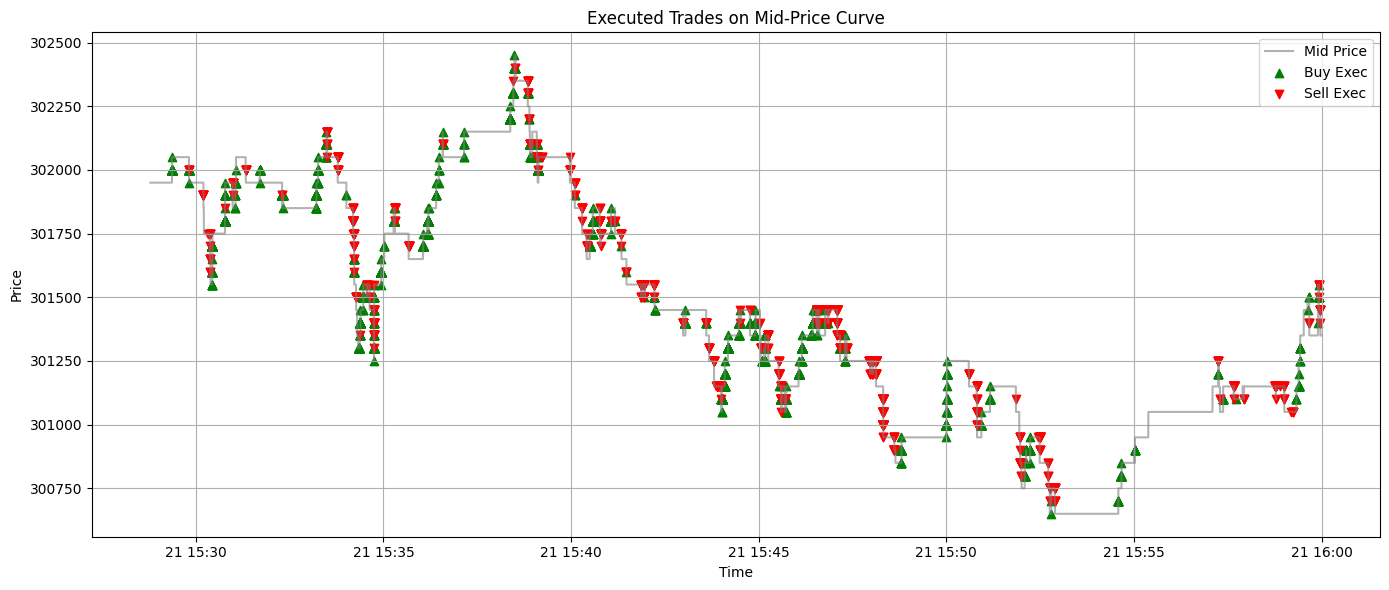

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(signal_stream['mid_price'], label='Mid Price', color='gray', alpha=0.6)
buy_signals = signal_stream[signal_stream['signal'] == 'Buy']
sell_signals = signal_stream[signal_stream['signal'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['exec_price'], label='Buy Exec', color='green', marker='^')
plt.scatter(sell_signals.index, sell_signals['exec_price'], label='Sell Exec', color='red', marker='v')

plt.title("Executed Trades on Mid-Price Curve")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Order Size Logic

### Fixed Order Size = $1$

In [26]:
signal_stream["order_size"] = signal_stream["signal"].map({'Sell':-1, 'Hold' :0, 'Buy' : 1})

### Confidence Weighted Order Size

In [27]:
probs = RF_Classifier.predict_proba(X_test)
labels = RF_Classifier.classes_
label_to_idx = {label: idx for idx, label in enumerate(labels)}
predicted_classes = RF_Classifier.predict(X_test)
predicted_idx = np.vectorize(label_to_idx.get)(predicted_classes)

confidence = probs[np.arange(len(probs)), predicted_idx]
confidence = pd.Series(confidence, index=X_test.index)
signal_stream["confidence"] = confidence[:len(signal_stream)]

## Backtesting Framework

### P&L per trade

In [28]:
trades = signal_stream.dropna(subset=["exec_price", "next_mid"])
trades = trades[trades['order_size'] != 0]

In [29]:
trades["pnl"] = (trades["next_mid"] - trades["exec_price"]) * trades["order_size"]
trades["cumulative_pnl"] = trades["pnl"].cumsum()

In [30]:
intitial_capital = 1e6
trades[ "equity"] = intitial_capital + trades["cumulative_pnl"]
trades["cumulative_return"] = trades["equity"] / intitial_capital - 1

### Sharpe Ratio

In [31]:
trades["returns"] = trades["pnl"] / intitial_capital
returns = trades["returns"].dropna()
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252 * 6.5 * 60 * 60 * 1000)
print(f"Sharpe Ratio :\t{sharpe_ratio}")

Sharpe Ratio :	-5.940966600297453e+20


### Maximum drawdown

In [32]:
equity = trades["equity"]
rolling_max = equity.cummax()
drawdown = rolling_max - equity
max_drawdown = drawdown.max()
print("Max Drawdown :\t", max_drawdown)

Max Drawdown :	 0.3561498096678406


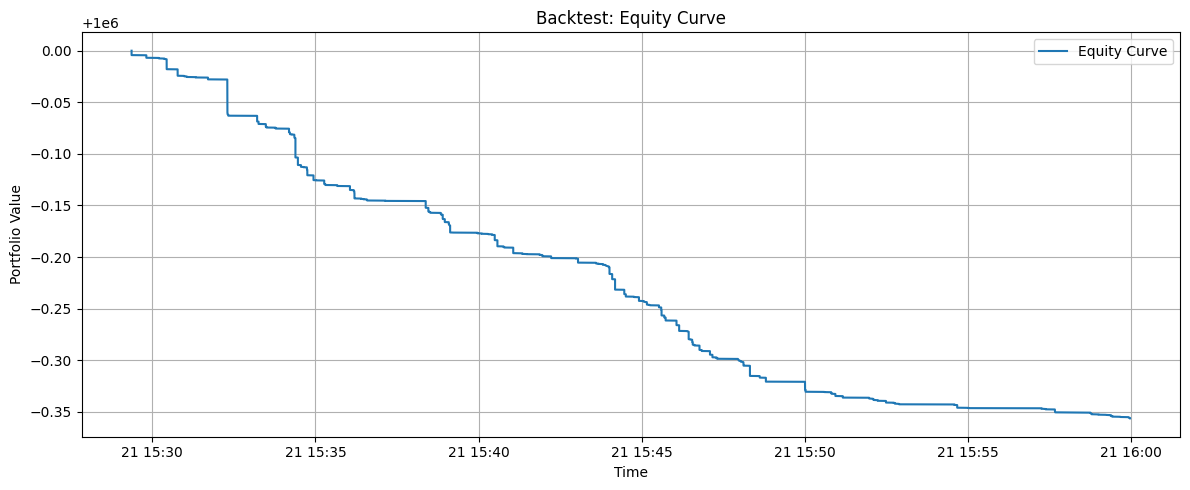

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(trades['equity'], label='Equity Curve')
plt.title("Backtest: Equity Curve")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Real-Time Feasibility

## Shap

In [35]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [36]:
X_sample = X_test.sample(n=1000)

explainer = shap.TreeExplainer(RF_Classifier)
shap_values = explainer.shap_values(X_sample)

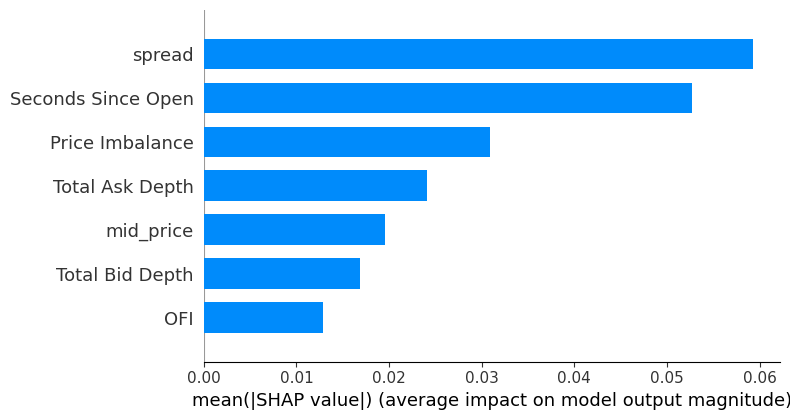

In [38]:
class_idx = list(RF_Classifier.classes_).index(1)
shap.summary_plot(shap_values[class_idx], X_sample, plot_type="bar")

## Permutation Importance

In [39]:
from sklearn.inspection import permutation_importance

In [40]:
perm_imp = permutation_importance(RF_Classifier, X_test, y_test, n_repeats=10)

In [46]:
perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_imp.importances_mean,
    'std': perm_imp.importances_std
}).sort_values(by='importance', ascending=False)

print("Features ranked by Permutation Importance:")
print(perm_df.sort_values(["importance"], ascending=False))

Features ranked by Permutation Importance:
              feature  importance       std
2     Price Imbalance    0.020586  0.000616
4     Total Ask Depth    0.013227  0.000432
1              spread    0.011583  0.000455
5                 OFI    0.002436  0.000378
0           mid_price    0.000373  0.000115
6  Seconds Since Open    0.000000  0.000000
3     Total Bid Depth   -0.000172  0.000477
